### FE621 - Homework #1

**Author**: Sid Bhatia

**Date**: February 11th, 2023

**Pledge**: I pledge my honor that I have abided by the Stevens Honor System.

**Professor**: Dr. Sveinn Olafsson

**TA**: Mr. Dong Woo Kim

#### Problem #1 - Analyzing Options Data

1. Collect Data:

- Download market prices and implied volatilities for S&P 500 index options (SPX options). You also need the value of the S&P 500 index. The data can be obtained from, e.g., Yahoo Finance or Bloomberg.
- Download risk-free interest rate data from http://www.federalreserve.gov/releases/H15/Current/.

In [105]:
from yahoo_fin import options
from yahoo_fin.stock_info import *

# Use "^SPX" for the S&P 500 Index.
ticker_symbol = '^SPX'

# Try-except to retrieve options data for ^SPX.
try:
    # Get all available expiration dates for the ticker.
    expiration_dates = options.get_expiration_dates(ticker_symbol)

    print(expiration_dates)
    
    if expiration_dates:
        # Get options chain for the nearest expiration date.
        options_chain = options.get_options_chain(ticker_symbol, expiration_dates[0])

        calls = options_chain['calls']
        puts = options_chain['puts']

        print("Calls Data:\n", calls.head())  # Display the first few rows of call options data.
        print("\nPuts Data:\n", puts.head())  # Display the first few rows of put options data.
    else:
        print("No expiration dates found for ticker:", ticker_symbol)
except Exception as e:
    print("Error retrieving options data:", str(e))

['February 12, 2024', 'February 13, 2024', 'February 14, 2024', 'February 15, 2024', 'February 16, 2024', 'February 20, 2024', 'February 21, 2024', 'February 22, 2024', 'February 23, 2024', 'February 26, 2024', 'February 27, 2024', 'February 28, 2024', 'February 29, 2024', 'March 1, 2024', 'March 4, 2024', 'March 5, 2024', 'March 6, 2024', 'March 7, 2024', 'March 8, 2024', 'March 11, 2024', 'March 12, 2024', 'March 13, 2024', 'March 14, 2024', 'March 15, 2024', 'March 18, 2024', 'March 19, 2024', 'March 22, 2024', 'March 25, 2024', 'March 28, 2024', 'April 5, 2024', 'April 19, 2024', 'April 30, 2024', 'May 17, 2024', 'May 31, 2024', 'June 21, 2024', 'June 28, 2024', 'July 19, 2024', 'July 31, 2024', 'August 16, 2024', 'September 20, 2024', 'September 30, 2024', 'October 18, 2024', 'November 15, 2024', 'December 20, 2024', 'December 31, 2024', 'January 17, 2025', 'February 21, 2025', 'March 21, 2025', 'June 20, 2025', 'December 19, 2025', 'March 20, 2026', 'December 18, 2026', 'December

In [220]:
import pandas as pd

# Load the CSV file for the risk-free rate.
rfr_df = pd.read_csv('FRB_H15.csv')

# Display the first few rows of the dataframe.
print(rfr_df.head())
print(rfr_df.tail())

print(rfr_df.columns)

# Drop NAs in risk-free rate data frame.
rfr_df_nonan = rfr_df.dropna(subset=['Market yield on U.S. Treasury securities at 3-month  constant maturity, quoted on investment basis'])

# Retrieve latest risk-free rate based on 3-month Treasury as of 2/8.
rfr = rfr_df_nonan['Market yield on U.S. Treasury securities at 3-month  constant maturity, quoted on investment basis'].iloc[-1]

rfr = float(rfr) / 100

print("Current Risk-Free Interest Rate as of 2/8:", rfr)

   Series Description   
0               Unit:  \
1         Multiplier:   
2           Currency:   
3  Unique Identifier:   
4         Time Period   

  Market yield on U.S. Treasury securities at 1-month  constant maturity, quoted on investment basis   
0                                  Percent:_Per_Year                                                  \
1                                                  1                                                   
2                                                NaN                                                   
3                             H15/H15/RIFLGFCM01_N.B                                                   
4                                     RIFLGFCM01_N.B                                                   

  Market yield on U.S. Treasury securities at 3-month  constant maturity, quoted on investment basis   
0                                  Percent:_Per_Year                                                  \
1               

2. Write a function that computes implied volatilities:

- Implement a function that computes the Black-Scholes prices of call and put options with parameters $S_0$ (stock price), $\sigma$ (vol), $\tau = T- t$ (time to maturity), $K$ (strike), $r$ (interest rate), and $\delta$ (dividend yield).
- Implement a function that uses Newton’s method to compute the implied volatility of call and put options.
Provide pseudocode for your approach (i.e., provide step-by-step algorithmic instructions).
- *Note: Newton’s method requires computing the derivative of the Black-Scholes price with respect to the
volatility σ. This derivative is known as vega and it has a closed-form formula in the Black-Scholes model.*

**Black-Scholes Price Calculation Pseudocode**

```plaintext
function black_scholes(S_0, K, r, tau, sigma, delta, option_type):
    Calculate d1 and d2 using their formulas
    if option_type is "call":
        C = S_0 * exp(-delta * tau) * N(d1) - K * exp(-r * tau) * N(d2)
        return C
    else if option_type is "put":
        P = K * exp(-r * tau) * N(-d2) - S_0 * exp(-delta * tau) * N(-d1)
        return P

In [207]:
from typing import Union
import numpy as np
import scipy.stats as si

def black_scholes(S_0: float, K: float, r: float, tau: float, sigma: float, delta: float, option_type: str) -> float:
    """
    Calculate the Black-Scholes option price for a call or put option.

    Parameters:
    - S_0 (float): Initial stock price.
    - K (float): Strike price.
    - r (float): Risk-free interest rate.
    - tau (float): Time to maturity (in years).
    - sigma (float): Volatility of the underlying asset.
    - delta (float): Continuous dividend yield.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: The Black-Scholes price of the option.
    """
    d1 = (np.log(S_0 / K) + (r - delta + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    if option_type == "call":
        price = S_0 * np.exp(-delta * tau) * si.norm.cdf(d1) - K * np.exp(-r * tau) * si.norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * tau) * si.norm.cdf(-d2) - S_0 * np.exp(-delta * tau) * si.norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")
    
    return price

## TEST CASES: $6.31, $4.83, $13.55, $11.82

# print(black_scholes(100, 100, 0.05, 0.5, 0.2, 0.02, "call")) // Correct
# print(black_scholes(100, 100, 0.05, 0.5, 0.2, 0.02, "put")) // Correct
# print(black_scholes(105, 100, 0.05, 1, 0.25, 0.03, "call")) // Correct
# print(black_scholes(95, 100, 0.05, 1, 0.30, 0.01, "put")) // Correct

6.307635154954198
4.833642982870657
13.552884258002848
11.820371089555387


**Implied Volatility Calculation Using Newton's Method**

```plaintext
function compute_implied_volatility(market_price, S_0, K, r, tau, delta, option_type):
    Initialize sigma with an initial guess, e.g., 0.2
    tolerance = 1e-6
    max_iterations = 100
    for i in 1 to max_iterations:
        Calculate the Black-Scholes price for the current sigma
        Compute Vega for the current sigma
        Calculate f(sigma) as the difference between Black-Scholes price and market_price
        Update sigma using Newton's method formula
        if absolute difference in sigma is less than tolerance:
            break
    return sigma

In [210]:
def vega(S_0: float, K: float, r: float, tau: float, sigma: float, delta: float) -> float:
    """
    Calculate Vega of an option, which is the sensitivity of the option price to a change in volatility.

    Parameters:
    - S_0, K, r, tau, sigma, delta: As described in the black_scholes function.

    Returns:
    - float: Vega of the option.
    """
    d1 = (np.log(S_0 / K) + (r - delta + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    return S_0 * np.exp(-delta * tau) * np.sqrt(tau) * si.norm.pdf(d1)

## TEST CASES: 27.50, 36.59, 15.12

# print(vega(100, 100, 0.05, 0.50, 0.20, 0.02)) // Correct
# print(vega(110, 100, 0.03, 1, 0.25, 0.01)) // Correct
# print(vega(90, 100, 0.05, 0.25, 0.30, 0.02)) // Correct

27.495794411964393
36.587356948113396
15.120124300057645


In [214]:
def compute_implied_volatility(market_price: float, S_0: float, K: float, r: float, tau: float, delta: float, option_type: str) -> float:
    """
    Compute the implied volatility of a call or put option using Newton's method.

    Parameters:
    - market_price (float): Market price of the option.
    - S_0, K, r, tau, delta: As described in the black_scholes function.
    - option_type (str): Type of the option ('call' or 'put').

    Returns:
    - float: Implied volatility of the option.
    """
    sigma = 0.2  # Initial guess for volatility.
    tolerance = 1e-6  # Convergence criterion.
    max_iterations = 100  # Maximum number of iterations.
    
    for _ in range(max_iterations):
        # Calculate the Black-Scholes price with the current guess for volatility.
        price = black_scholes(S_0, K, r, tau, sigma, delta, option_type)
        
        # Calculate Vega, the derivative of price with respect to volatility.
        option_vega = vega(S_0, K, r, tau, sigma, delta)
        
        # Difference between market price and model price.
        price_diff = market_price - price
        
        # Prevent division by zero.
        if abs(option_vega) < 1e-8:
            break
        
        # Update guess for sigma using Newton's method.
        sigma_new = sigma + price_diff / option_vega
        
        # Check if the change in sigma is within the tolerance level.
        if abs(sigma_new - sigma) < tolerance:
            return sigma_new
        
        sigma = sigma_new
    
    return sigma

## TEST CASES: 24.38%, 18.94%

# print(compute_implied_volatility(1.37, 90, 100, 0.05, 0.25, 0.02, 'call')) // Correct
# print(compute_implied_volatility(1.37, 188.85, 190.00, 4.86/100, 6/365, 0.63/100, 'call')) // Correct

3. Generate implied volatility smiles:

- Use your function in part (b) to compute the implied volatilities of options with the following maturities: 1 month, 3 months, 6 months, 1 year. You may also consider other maturities. For the market price of an option, use the average of the bid and ask prices.
- For each maturity, plot your computed implied volatilities and the downloaded market implied volatilities. Do this for both call and put options. How do the computed and market volatilities compare?
- *Note: Rather than plotting implied volatilities as a function of strike price, you may explore plotting them as a function of the so-called option moneyness. The moneyness is commonly defined as $\frac{S_0}{K}$, or $\frac{ln(\frac{K}{F})}{\sigma_{\text{ATM}}\sqrt{\tau}}$, where $F = S_0e^{r\tau}$ is the forward price, and $\sigma_{\text{ATM}}$ is the implied volatility of the ATM option (i.e., the option with strike $K \approx F$).*

In [215]:
import matplotlib.pyplot as plt
import yfinance as yf

# Define the ticker symbol for the S&P 500 ETF.
ticker_symbol = 'SPY'

# Fetch data.
spy_data = yf.Ticker(ticker_symbol)

# Get the latest close price.
spy_hist = spy_data.history(period="1d")  # Fetches the last day's data.

# Extracting the closing price.
spy_close_price = spy_hist['Close'].iloc[0]

spot = spy_close_price

dividend_yield = 0.0137
delta = dividend_yield

print(spot)
print(delta)
print(expiration_dates)

501.20001220703125
0.0137
['February 12, 2024', 'February 13, 2024', 'February 14, 2024', 'February 15, 2024', 'February 16, 2024', 'February 20, 2024', 'February 21, 2024', 'February 22, 2024', 'February 23, 2024', 'February 26, 2024', 'February 27, 2024', 'February 28, 2024', 'February 29, 2024', 'March 1, 2024', 'March 4, 2024', 'March 5, 2024', 'March 6, 2024', 'March 7, 2024', 'March 8, 2024', 'March 11, 2024', 'March 12, 2024', 'March 13, 2024', 'March 14, 2024', 'March 15, 2024', 'March 18, 2024', 'March 19, 2024', 'March 22, 2024', 'March 25, 2024', 'March 28, 2024', 'April 5, 2024', 'April 19, 2024', 'April 30, 2024', 'May 17, 2024', 'May 31, 2024', 'June 21, 2024', 'June 28, 2024', 'July 19, 2024', 'July 31, 2024', 'August 16, 2024', 'September 20, 2024', 'September 30, 2024', 'October 18, 2024', 'November 15, 2024', 'December 20, 2024', 'December 31, 2024', 'January 17, 2025', 'February 21, 2025', 'March 21, 2025', 'June 20, 2025', 'December 19, 2025', 'March 20, 2026', 'Dec

In [167]:
# from datetime import datetime

# current_date = datetime(2024, 2, 11)
# expiration_date__str_1_mth = 'March 11, 2024'
# expiration_date_1_mth = datetime.strptime(expiration_date__str_1_mth, '%B %d, %Y')

# tau_1_mth = (expiration_date_1_mth - current_date).days / 365

# print(tau_1_mth)

# expiration_date__str_3_mth = 'May 17, 2024'
# expiration_date_3_mth = datetime.strptime(expiration_date__str_3_mth, '%B %d, %Y')
# tau_3_mth = (expiration_date_3_mth - current_date).days / 365

# print(tau_3_mth)

# expiration_date__str_6_mth = 'August 16, 2024'
# expiration_date_6_mth = datetime.strptime(expiration_date__str_6_mth, '%B %d, %Y')
# tau_6_mth = (expiration_date_6_mth - current_date).days / 365

# print(tau_6_mth)

# expiration_date__str_1_yr = 'February 15, 2025'
# expiration_date_1_yr = datetime.strptime(expiration_date__str_1_yr, '%B %d, %Y')
# tau_1_yr = (expiration_date_1_yr - current_date).days / 365

# print(tau_1_yr)

In [216]:
import pandas as pd

# Drop rows where column 'Bid' contains '-'.
calls = calls.loc[calls['Bid'] != '-']
puts = puts.loc[puts['Bid'] != '-']

calls['Bid'] = pd.to_numeric(calls['Bid'])
calls['Ask'] = pd.to_numeric(calls['Ask'])
puts['Bid'] = pd.to_numeric(puts['Bid'])
puts['Ask'] = pd.to_numeric(puts['Ask'])

calls_mid = (calls['Bid'] + calls['Ask']) / 2
# print(calls_mid)

puts_mid = (puts['Bid'] + puts['Ask']) / 2
# print(puts_mid)

maturities = [1/12, 1/4, 1/2, 1]

computed_call_iv_1_mth = []
computed_put_iv_1_mth = []

call_strikes = pd.to_numeric(calls['Strike'])
put_strikes = pd.to_numeric(puts['Strike'])

print(call_strikes)
print(put_strikes)

# for idx, strike in call_strikes.items():
#     market_price = calls_mid.iloc[idx]  # Access the corresponding market price
#     computed_call_iv_1_mth.append(compute_implied_volatility(market_price, spot, strike, rfr, 1/12, delta, 'call'))

0      1200.0
1      2000.0
2      2400.0
3      2600.0
4      4000.0
        ...  
149    5400.0
150    5500.0
151    5600.0
152    5800.0
153    6000.0
Name: Strike, Length: 140, dtype: float64
0      1200.0
1      1800.0
2      2000.0
3      2200.0
4      2400.0
        ...  
152    5180.0
153    5200.0
154    5800.0
155    6000.0
156    6400.0
Name: Strike, Length: 156, dtype: float64


In [87]:
# import matplotlib.pyplot as plt

# # Define maturities in years.
# maturities = [1/12, 1/4, 1/2, 1]

# spots = 

# # Receive expirations.
# expiration_dates

# # Compute implied volatilities for each maturity.
# computed_call_iv = []
# computed_put_iv = []

# columns = calls.columns

# print(columns)

# for maturity in maturities:
#     # Compute the implied volatilities for call options
#     computed_call_iv.append([compute_implied_volatility((call['Bid'] + call['Ask']) / 2, S_0, call['Strike'], rfr, maturity, 0, 'call') for _, call in calls.iterrows()])
#     # Compute the implied volatilities for put options
#     computed_put_iv.append([compute_implied_volatility((put['Bid'] + put['Ask']) / 2, S_0, put['Strike'], rfr, maturity, 0, 'put') for _, put in puts.iterrows()])

# # Plot the computed implied volatilities for call options
# plt.figure(figsize=(12, 8))
# for i, maturity in enumerate(maturities):
#     plt.plot(computed_call_iv[i], label=f'{int(maturity*12)}-month Call')

# plt.xlabel('Option Index')
# plt.ylabel('Implied Volatility')
# plt.title('Computed Implied Volatilities for Call Options')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the computed implied volatilities for put options
# plt.figure(figsize=(12, 8))
# for i, maturity in enumerate(maturities):
#     plt.plot(computed_put_iv[i], label=f'{int(maturity*12)}-month Put')

# plt.xlabel('Option Index')
# plt.ylabel('Implied Volatility')
# plt.title('Computed Implied Volatilities for Put Options')
# plt.legend()
# plt.grid(True)
# plt.show()

Index(['Contract Name', 'Last Trade Date', 'Strike', 'Last Price', 'Bid',
       'Ask', 'Change', '% Change', 'Volume', 'Open Interest',
       'Implied Volatility'],
      dtype='object')


#### Problem #2 - Root Finding Algorithms

1. Write pseudocode for using the bisection method and Newton’s method to iteratively compute the square root
of a positive number $a$. Remember to state how you choose the initial search interval for the bisection method,
and the initial guess for Newton’s method.
- *Hint: Finding the square root of $a$ is equivalent to finding the positive root of the function $f(x) = x^2 - a$.*

**Bisection Method Pseudocode**

The bisection method requires selecting an initial interval $[x_0, x_1]$ that contains the root.

1. *Initial Interval Selection*:
   - Choose `x_0 = 0` and `x_1 = a` if `a >= 1` or `x_1 = 1` if `a < 1`. This ensures the square root of `a` is within the interval `[x_0, x_1]`.

2. *Check Midpoint*:
   - Compute the midpoint `m = (x_0 + x_1) / 2` and evaluate `f(m) = m^2 - a`.

3. *Update Interval*:
   - If `f(m) = 0`, then `m` is the square root, and the process stops.
   - If `f(m) * f(x_0) < 0`, the root is in the interval `[x_0, m]`. Set `x_1 = m`.
   - Otherwise, the root is in the interval `[m, x_1]`. Set `x_0 = m`.

4. *Convergence Check*:
   - Repeat steps 2 and 3 until the interval `[x_0, x_1]` is sufficiently small, e.g., `|x_1 - x_0| < epsilon`, where `epsilon` is a small number representing the desired accuracy.

5. *Result*:
   - The square root of `a` is approximately `(x_0 + x_1) / 2` after convergence.

**Newton's Method Pseudocode**

1. *Initial Guess*:
   - Choose `x_0 = a / 2` if `a >= 1` or `x_0 = 1` if `a < 1`. This is a reasonable starting point for most positive numbers `a`.

2. *Iteration*:
   - Apply the Newton iteration formula to refine the guess: `x_{n+1} = x_n - (f(x_n) / f'(x_n)) = x_n - ((x_n^2 - a) / (2x_n)) = (x_n + (a / x_n)) / 2`.

3. *Convergence Check*:
   - Repeat step 2 until the change in successive estimates is below a threshold, e.g., `|x_{n+1} - x_n| < epsilon`, where `epsilon` is the desired precision.

4. *Result*:
   - The square root of `a` is `x_n` when the process converges.

2. Implement your procedures in part (a) with tolerance $\epsilon = 10^{-6}$.
    1. How many iterations do the algorithms need for $a = 0.5$ and $a = 2$?
    2. To visualize the convergence, plot $|err_n|$ as a function of $n$ ($|err_n|$ should converge to zero), and $\log(|err_n|)$ as a function of $\log(n)$, where $err_n = \sqrt{a} - x_n$ is the error on the $n$-th iteration of the algorithm.
    3. Which algorithm seems to converge faster? Is what you observe in line with theoretical results about the rate of convergence of the two methods?

##### 2bi.

In [80]:
def sqrt_bisection(a: float, epsilon: float = 1e-6) -> float:
    if a < 0:
        raise ValueError("a must be non-negative")
    elif a == 0 or a == 1:
        return a
    
    lower, upper = (0, a) if a > 1 else (a, 1)
    
    while upper - lower > epsilon:
        midpoint = (lower + upper) / 2
        if midpoint**2 == a:
            return midpoint
        elif midpoint**2 < a:
            lower = midpoint
        else:
            upper = midpoint
    
    return (lower + upper) / 2

print(sqrt_bisection(0.5))
print(sqrt_bisection(2))

0.7071070671081543
1.4142136573791504


In [79]:
def sqrt_newton(a: float, epsilon: float = 1e-6) -> float:
    if a < 0:
        raise ValueError("a must be non-negative")
    elif a == 0 or a == 1:
        return a
    
    x_n = a / 2  # Initial guess
    while True:
        x_next = 0.5 * (x_n + a / x_n)
        if abs(x_next - x_n) < epsilon:
            return x_next
        x_n = x_next

print(sqrt_newton(0.5))
print(sqrt_newton(2))

0.7071067811865475
1.414213562373095


##### 2bii.

In [74]:
def sqrt_bisection_iterations(a: float, epsilon: float = 1e-6) -> int:
    if a == 0 or a == 1:
        return 0  # No iterations needed
    lower, upper = (0, a) if a > 1 else (a, 1)
    iterations = 0
    while upper - lower > epsilon:
        midpoint = (lower + upper) / 2
        if midpoint**2 < a:
            lower = midpoint
        else:
            upper = midpoint
        iterations += 1
    return iterations

def sqrt_newton_iterations(a: float, epsilon: float = 1e-6) -> int:
    if a == 0 or a == 1:
        return 0  # No iterations needed
    x_n = a / 2
    iterations = 0
    while True:
        x_next = 0.5 * (x_n + a / x_n)
        if abs(x_next - x_n) < epsilon:
            break
        x_n = x_next
        iterations += 1
    return iterations

# Calculate and print the number of iterations for each method and value of a.
for a in [0.5, 2]:
    bisection_iters = sqrt_bisection_iterations(a)
    newton_iters = sqrt_newton_iterations(a)
    print(f"For a = {a}: Bisection method iterations = {bisection_iters}, Newton's method iterations = {newton_iters}")

For a = 0.5: Bisection method iterations = 19, Newton's method iterations = 5
For a = 2: Bisection method iterations = 21, Newton's method iterations = 4


##### 2biii.

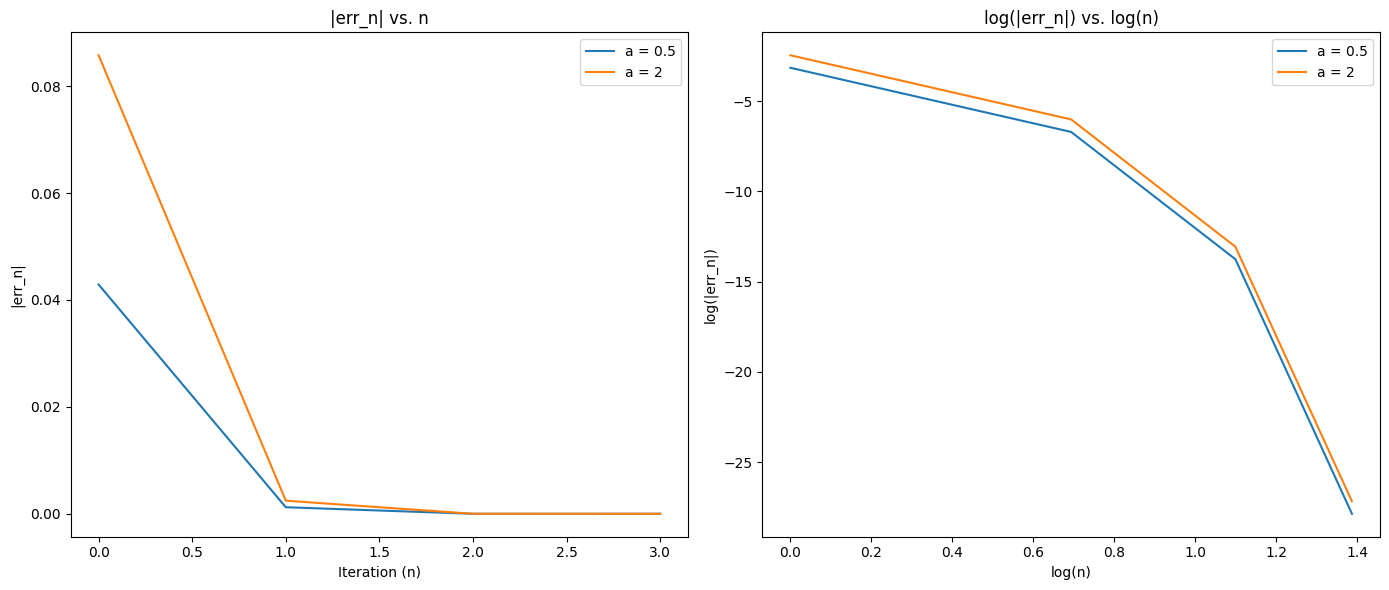

In [82]:
def sqrt_newton_with_errors(a: float, epsilon: float = 1e-6):
    if a <= 0:
        raise ValueError("a must be positive")
    
    x_n = a if a < 1 else a / 2  # Initial guess
    errors = []  # To track errors
    
    while True:
        x_next = 0.5 * (x_n + a / x_n)
        err_n = np.abs(np.sqrt(a) - x_next)
        errors.append(err_n)
        if err_n < epsilon:
            break
        x_n = x_next

    return errors

# Compute errors for a = 0.5 and a = 2
errors_05 = sqrt_newton_with_errors(0.5)
errors_2 = sqrt_newton_with_errors(2)

# Plot |err_n| as a function of n
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(errors_05, label='a = 0.5')
plt.plot(errors_2, label='a = 2')
plt.xlabel('Iteration (n)')
plt.ylabel('|err_n|')
plt.title('|err_n| vs. n')
plt.legend()

# Plot log(|err_n|) vs log(n)
plt.subplot(1, 2, 2)
n_05 = np.arange(1, len(errors_05) + 1)
n_2 = np.arange(1, len(errors_2) + 1)
plt.plot(np.log(n_05), np.log(errors_05), label='a = 0.5')
plt.plot(np.log(n_2), np.log(errors_2), label='a = 2')
plt.xlabel('log(n)')
plt.ylabel('log(|err_n|)')
plt.title('log(|err_n|) vs. log(n)')
plt.legend()

plt.tight_layout()
plt.show()

3. *Extra credit:* Show theoretically that Newton’s method has *quadratic order of convergence*. Specifically, denote by $x^*$ a solution of $f(x) = 0$ for some "nice" function $f$, and let $\epsilon_n = |x_n - x^*|$ be the error on the $n$-th iteration of  Newton’s algorithm. Show that $$\epsilon_{n+1} \leq K\epsilon^2_n,$$ for some constant $K > 0$, which is the definition of quadratic order of convergence.
- *Remark: For comparison, the error of the bisection method satisfies $$\epsilon_{n+1} \leq \frac{1}{2}\epsilon_n,$$ where $\epsilon_n = |x_n - x^*|$ is the error on the $n$-th iteration, and $x_n = (b_n - a_n) / 2$ is the half-width of the $n$-th interval $(a_n, b_n)$. This is called linear order of convergence.*

To demonstrate that Newton's method has quadratic order of convergence, we consider the Newton iteration formula and apply Taylor expansion of $f(x)$ around a root $x^*$, assuming $f$ is twice differentiable in the neighborhood of $x^*$.

The iteration formula for Newton's method is:

$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$


Let $\epsilon_n = |x_n - x^*|$ denote the error on the $n$-th iteration. Our aim is to show that $\epsilon_{n+1} \leq K\epsilon_n^2$ for some constant $K > 0$.

Taylor's theorem allows us to expand $f(x)$ around $x^*$:

$$
f(x_n) = f(x^*) + f'(x^*)(x_n - x^*) + \frac{f''(\xi_n)}{2}(x_n - x^*)^2
$$

where $\xi_n$ is some point between $x_n$ and $x^*$. Given $x^*$ is a root of $f(x) = 0$, this simplifies to:

$$
f(x_n) = f'(x^*)\epsilon_n + \frac{f''(\xi_n)}{2}\epsilon_n^2
$$

Substituting the Taylor expansion back into Newton's iteration formula yields:

$$
x_{n+1} = x_n - \frac{f'(x^*)\epsilon_n + \frac{f''(\xi_n)}{2}\epsilon_n^2}{f'(x_n)}
$$

Assuming $f'(x^*) \neq 0$ and that $f'(x_n)$ approximates $f'(x^*)$ closely as $n$ increases, we get:

$$
\epsilon_{n+1} = |x_{n+1} - x^*| \approx \left| -\frac{f''(\xi_n)}{2f'(x^*)}\epsilon_n^2 \right|
$$

This demonstrates that $\epsilon_{n+1}$ is proportional to $\epsilon_n^2$, indicative of quadratic convergence. Here, $K = \left| \frac{f''(\xi_n)}{2f'(x^*)} \right|$ is a constant, showcasing the efficiency of Newton's method for well-behaved functions, as it implies the precision roughly doubles with each iteration.
